# Exploratory Data Analysis

In this notebook I'll explore each variable presented in the dataset.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Folders
analysis_folder = os.getcwd()
input_data = os.path.join(analysis_folder, 'challenge.json')

# Open dataset
df = pd.read_json(input_data)

In [2]:
n_orders, n_variables = df.shape

print('The dataset has %i orders and %i variables.' % (n_orders, n_variables))

The dataset has 204428 orders and 14 variables.


## Check Missing Data

In [3]:
df.isnull().sum()

branch_id              0
customer_code          0
group_code             0
is_churn            1915
item_code              0
item_total_price       0
order_id               0
quantity               0
register_date          0
sales_channel          0
segment_code           0
seller_code            0
total_price            0
unit_price             0
dtype: int64

In [4]:
print('The variable "is_churn" has %1.2f%% of missing data.' % \
((df['is_churn'].isnull().sum() / np.float(df.shape[0])) * 100.))

The variable "is_churn" has 0.94% of missing data.


**NOTE**: During the preprocing of the data I could stopt a interesting behavior: all the customers from `group_code` #3 do not have values for the `is_churn` variable. 

In [5]:
df[df['group_code'] == 3]['is_churn'].unique()

array([nan])

## Number of customers, items and sellers
It is plausible to infer that each customer has a unique **customer_code**. The same approach goes to the **item_code** and **seller_code** variables.

In [6]:
n_customers = len(df['customer_code'].unique())
n_items = len(df['item_code'].unique())
n_sellers = len(df['seller_code'].unique())

print('The dataset has %i customers, %i sellers and %i items.' % (n_customers, n_sellers, n_items))

The dataset has 838 customers, 290 sellers and 2981 items.


## Numerical Variables

First let's start with the numerical variables.
* **quantity**: quantity of items, given by item_code, were bought;
* **unit_price**: unit price of this item;
* **item_total_price**: total price of items, i.e., quantity* price;
* **total_price**: total price of the order (sum of all items);

In [7]:
num_variables = ['quantity', 'unit_price', 'item_total_price', 'total_price']
df[num_variables].head()

,quantity,unit_price,item_total_price,total_price
0,10,25.04,292.91,1613.53
1,20,12.33,287.19,11163.69
2,12,12.80,184.84,6432.12
3,18,10.51,189.18,831.82
4,5,11.82,66.87,1736.48


In [8]:
df[num_variables].describe()

,quantity,unit_price,item_total_price,total_price
count,204428.000000,204428.000000,204428.000000,204428.000000
mean,12.332694,47.456664,304.048244,5337.072931
std,53.299314,145.295694,1009.268287,21268.855032
min,1.000000,0.010000,0.000000,0.010000
25%,3.000000,14.670000,79.600000,1180.470000
50%,6.000000,21.780000,156.150000,2035.820000
75%,12.000000,46.720000,293.862500,3611.070000
max,7000.000000,26280.000000,102951.110000,428976.460000


Looking at the **mean** and **maximum** values of these variables, it seems that they have a long tail on the right side of the distribution. In other words, they are not Gaussians. Therefore, it is better to plot their histograms using the log scale in the **y** axis.

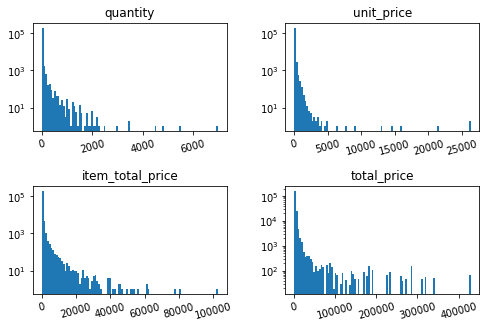

In [9]:
fig, axs = plt.subplots(2,2, figsize=(8,5))
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].hist(df[num_variables[i]], bins=100)
    axs[i].set_yscale('log')
    axs[i].xaxis.set_tick_params(rotation=15)
    title = str(num_variables[i])
    axs[i].set_title(title)
    
plt.show()

In [10]:
# Calculating the correlation matrix
num_corr = df[num_variables].corr(method='pearson')
num_corr

,quantity,unit_price,item_total_price,total_price
quantity,1.000000,0.070669,0.812810,0.364738
unit_price,0.070669,1.000000,0.143447,0.036071
item_total_price,0.812810,0.143447,1.000000,0.402906
total_price,0.364738,0.036071,0.402906,1.000000


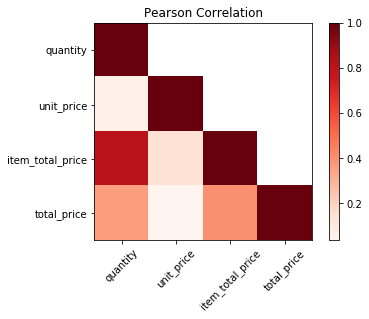

In [11]:
num_corr = num_corr.where(np.tril(np.ones(num_corr.shape)).astype(np.bool))

plt.imshow(num_corr, cmap=plt.cm.Reds, interpolation='nearest')
tick_marks = [i for i in range(len(num_variables))]
plt.xticks(tick_marks, num_variables, rotation='45')
plt.yticks(tick_marks, num_variables)
plt.title('Pearson Correlation')
plt.colorbar()
plt.show()

Biggest correlation is between the **quantity** and **item_total_price** variables.

## Categorical Variables: 

* **branch_id**: the branch id where this order was made;
* **sales_channel**: the sales channel this order was made;
* **group_code**: which group this customer belongs;
* **segment_code**: segment this client belongs;
* **is_churn**: True, if we believe the client will not come back.

In [12]:
cat_variables = ['branch_id', 'sales_channel', 'group_code', 'segment_code', 'is_churn']

print('Number of unique values in each categorical variable:\n')
for var in cat_variables:
    n_unique = df[var].nunique()
    print('%s: %i' % (var, n_unique))
print('')

Number of unique values in each categorical variable:

branch_id: 1
sales_channel: 106
group_code: 4
segment_code: 8
is_churn: 2



**NOTES:**
* The **branch_id** has only one unique value for the entire dataset, this won't add information in any model. 
* The variable **sales_channel** has more than a 100 unique values and deserves a more specific study. 

So let's skip these two features, for now, and concentrate on the others.

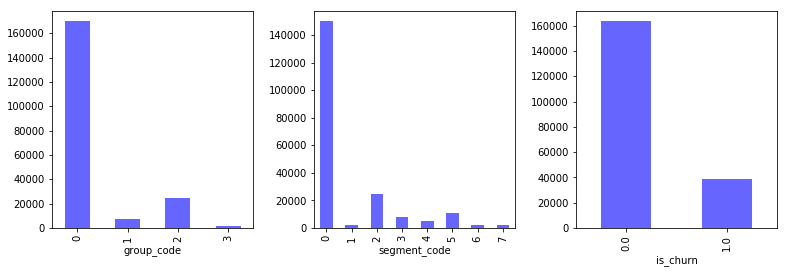

In [13]:
cat_variables = ['group_code', 'segment_code', 'is_churn']

fig, axs = plt.subplots(1,3, figsize=(13,4))
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()

for i, var in enumerate(cat_variables):
    df.groupby(var)[var].size().plot(ax = axs[i], kind='bar', color='b', alpha=0.6)

The bar plot of the **is_churn** variable tells that the dataset in very unbalanced.

## Customer Group Statistcs

In [14]:
stat_group = df.groupby(['group_code'])['quantity'].describe()

print '======================='
print 'Quantity per Group Code:'
print '======================='
stat_group

Quantity per Group Code:


,count,mean,std,min,25%,50%,75%,max
group_code,,,,,,,,
0,170164.0,9.013123,26.289848,1.0,3.0,6.0,12.0,7000.0
1,7646.0,97.388962,225.245735,1.0,10.0,30.0,80.0,4800.0
2,24703.0,9.044893,26.411366,1.0,1.0,3.0,10.0,1060.0
3,1915.0,10.113316,17.078502,1.0,2.0,6.0,12.0,400.0


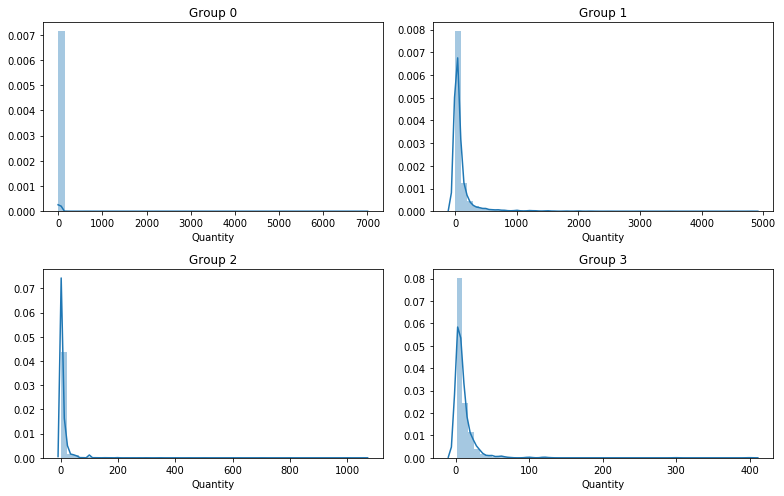

In [22]:
import seaborn as sns

plt.figure(figsize=(11,7))

plt.subplot(221)
plt.title('Group 0')
plt.xlabel('Quantity')
sns.distplot(df[df['group_code'] == 0]['quantity'].values, label='Group 0')

plt.subplot(222)
plt.title('Group 1')
plt.xlabel('Quantity')
sns.distplot(df[df['group_code'] == 1]['quantity'].values, label='Group 1')

plt.subplot(223)
plt.title('Group 2')
plt.xlabel('Quantity')
sns.distplot(df[df['group_code'] == 2]['quantity'].values, label='Group 2')

plt.subplot(224)
plt.title('Group 3')
plt.xlabel('Quantity')
sns.distplot(df[df['group_code'] == 3]['quantity'].values, label='Group 3')

plt.tight_layout()
plt.show()

In [16]:
stat_group = df.groupby(['group_code'])['unit_price'].describe()

print '=========================='
print 'Unit Price per Group Code:'
print '=========================='
stat_group

Unit Price per Group Code:


,count,mean,std,min,25%,50%,75%,max
group_code,,,,,,,,
0,170164.0,46.563045,80.096774,0.01,15.440,22.53,47.380,4876.80
1,7646.0,64.419347,613.619785,0.91,13.340,20.57,39.900,26280.00
2,24703.0,48.209071,114.962001,0.01,7.730,16.35,42.120,3115.00
3,1915.0,49.429723,93.000485,0.01,14.865,21.99,49.365,1513.57


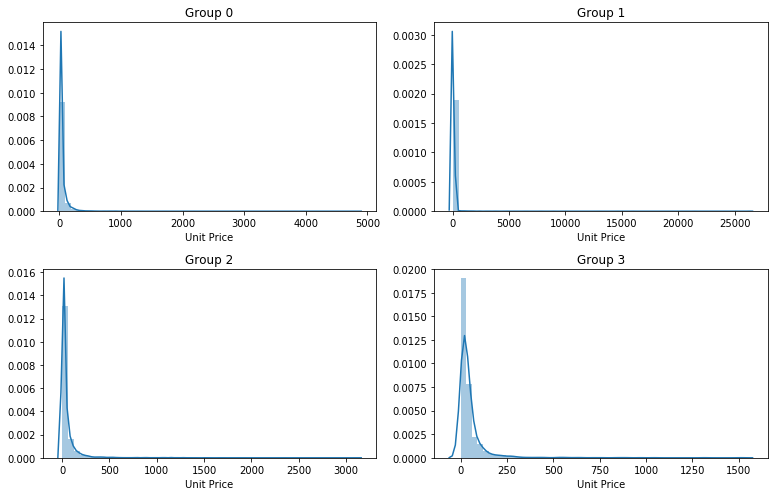

In [17]:
plt.figure(figsize=(11,7))

plt.subplot(221)
plt.title('Group 0')
plt.xlabel('Unit Price')
sns.distplot(df[df['group_code'] == 0]['unit_price'].values, label='Group 0')

plt.subplot(222)
plt.title('Group 1')
plt.xlabel('Unit Price')
sns.distplot(df[df['group_code'] == 1]['unit_price'].values, label='Group 1')

plt.subplot(223)
plt.title('Group 2')
plt.xlabel('Unit Price')
sns.distplot(df[df['group_code'] == 2]['unit_price'].values, label='Group 2')

plt.subplot(224)
plt.title('Group 3')
plt.xlabel('Unit Price')
sns.distplot(df[df['group_code'] == 3]['unit_price'].values, label='Group 3')

plt.tight_layout()
plt.show()

The group analysis couldn't spot a clear pattern of quantity and items price for each group of customers. All the distributions have large tails on the right side. Therefore, the values of **mean** and **std** of the described statistcs are not reliable, since the distribution is not Gaussian.

## Timestamp Variable

* **register_date**: date of the order;

In [18]:
df['register_date'].head()

0    2017-11-10T00:00:00Z
1    2011-05-16T00:00:00Z
2    2018-01-24T00:00:00Z
3    2010-07-28T00:00:00Z
4    2010-12-17T00:00:00Z
Name: register_date, dtype: object

Converting the **register_date** variable to the pandas *datetime* format.

In [19]:
df['register_date'] = pd.to_datetime(df['register_date'], format='%Y-%m-%dT%H:%M:%SZ')

In [20]:
df['register_date'].head()

0   2017-11-10
1   2011-05-16
2   2018-01-24
3   2010-07-28
4   2010-12-17
Name: register_date, dtype: datetime64[ns]

In [21]:
min_register_date = min(df['register_date'])
max_register_date = max(df['register_date'])

print('Date of the first register: %s' % str(min_register_date.date()))
print('Date of the last register: %s\n' % str(max_register_date.date()))

time_interval = (max_register_date - min_register_date).days
print('Total: %s days' % str(time_interval))

Date of the first register: 2008-01-04
Date of the last register: 2018-07-08

Total: 3838 days
